# Inference

In [1]:
import os
import sys
# Append the project root directory to sys.path
sys.path.append(os.path.abspath("/Users/prashal/dev/Face-Detector"))

from tensorflow.keras.optimizers import Adam
from math import ceil
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

from models.keras_ssd7 import build_model
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_DecodeDetections import DecodeDetections

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize

from misc_utils.utils import format_labels, create_virtual_folder
from eval_utils.average_precision_evaluator import Evaluator

In [2]:
### Build the model and load trained weights into it

img_height = 512
img_width = 512
n_classes = 1

ssd = build_model(
    image_size=(img_height, img_width, 3),
    n_classes=n_classes,
    mode='training',
    l2_regularization=0.0005,
    min_scale=0.07,
    max_scale=0.9,
    aspect_ratios_global=[0.5, 1.0, 2.0],
    aspect_ratios_per_layer=None,
    two_boxes_for_ar1=True,
    steps=None,
    offsets=None,
    clip_boxes=False,
    variances=[1.0, 1.0, 1.0, 1.0],
    normalize_coords=True,
    subtract_mean=127.5,
    divide_by_stddev=127.5
)

weights_path = '../tmp/checkpoints/ssd7_epoch-13_loss-2.0928_val_loss-2.1003.keras'
ssd.load_weights(weights_path)

adam = Adam(learning_rate=0.001)
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
ssd.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [3]:
orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.

img_path = '../examples/inputs/people.jpg'
from imageio.v2 import imread
from tensorflow.keras.preprocessing import image

orig_images.append(imread(img_path))
img = image.load_img(img_path, target_size=(img_height, img_width))
img = image.img_to_array(img) 
input_images.append(img)
input_images = np.array(input_images)

In [4]:
### Make predictions

y_pred = ssd.predict(input_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


In [5]:
### Decode the raw prediction `y_pred`

i = 0
y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.1,
                                   top_k=200,
                                   normalize_coords=True,
                                   img_height=img_height,
                                   img_width=img_width)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     0.99 197.59 108.59 239.95 192.73]
 [  1.     0.93 288.04  85.97 341.93 169.52]
 [  1.     0.93 419.64 118.66 474.13 203.12]
 [  1.     0.88  56.75  57.95 120.67 141.18]]


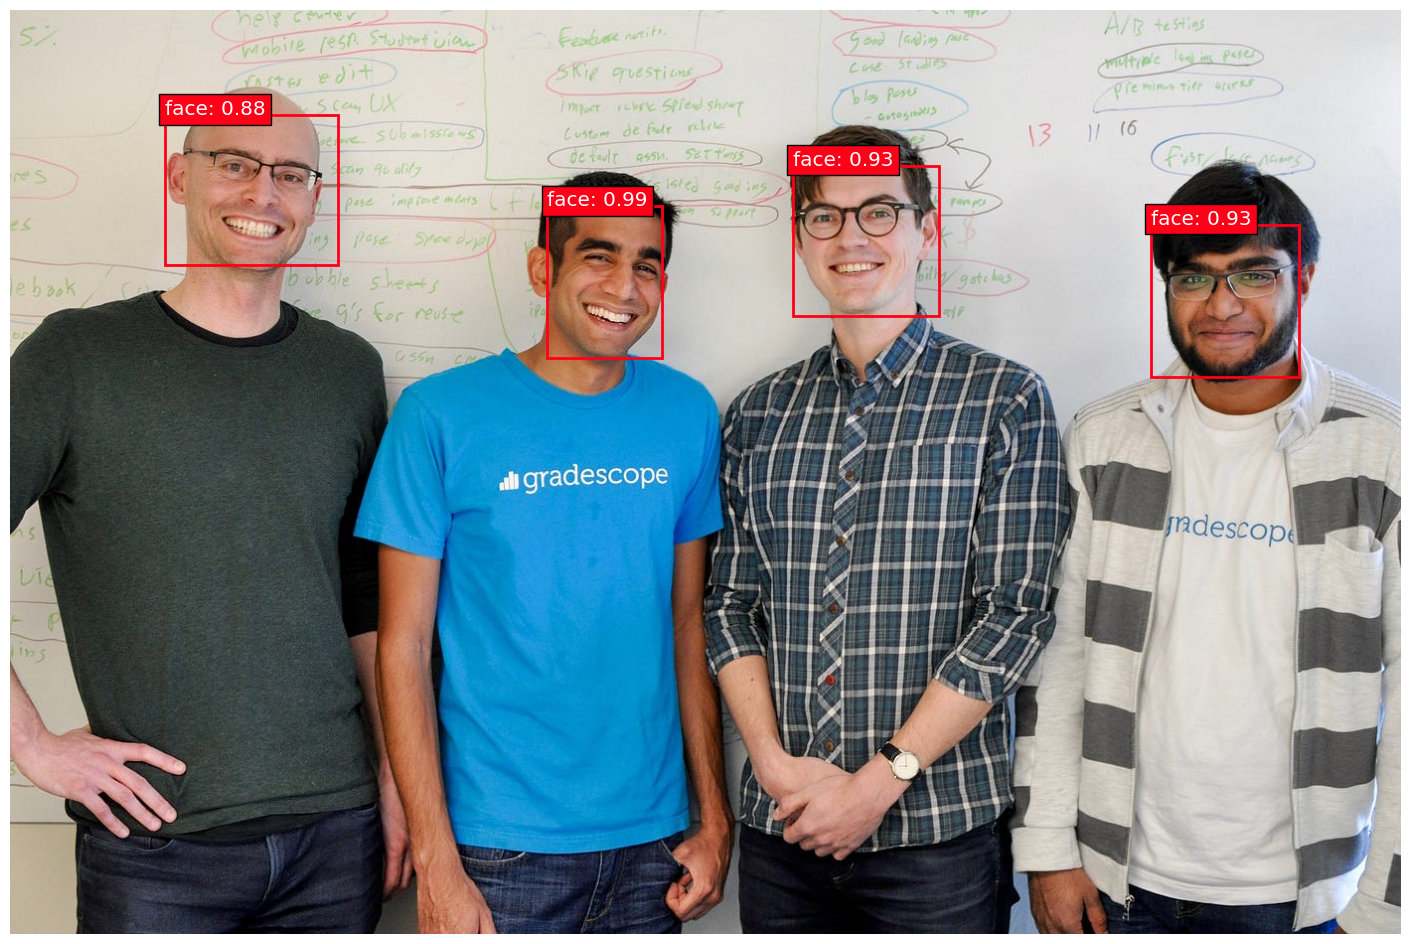

In [6]:
### Display the image and draw the predicted boxes onto it.

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()
classes = ['background', 'face']
plt.figure(figsize=(20,12))
plt.imshow(orig_images[0])
plt.axis('off')

current_axis = plt.gca()

for box in y_pred_decoded[i]:
    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
    xmin = box[2] * orig_images[0].shape[1] / img_width
    ymin = box[3] * orig_images[0].shape[0] / img_height
    xmax = box[4] * orig_images[0].shape[1] / img_width
    ymax = box[5] * orig_images[0].shape[0] / img_height
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

plt.savefig('../examples/outputs/people_annotated', bbox_inches='tight')
plt.show()

# Evaluation

In [7]:
### Create a data generator for the evaluation dataset. Since we don't have test set ground truth labels for wider face dataset, we are forced to evaluate on validation set

# Create symlinks to validation-set
src_folder_val = os.path.abspath("../wider_face/data/test/9--Press_Conference/")
virtual_folder_val = os.path.abspath("../wider_face/data/test_virtual_folder/images")
create_virtual_folder(src_folder_val, virtual_folder_val)
# Format validation set ground truth labels
val_labels_file = os.path.abspath("../wider_face/data/test/bbox.txt")
formatted_val_labels_file = os.path.abspath("../wider_face/data/test_virtual_folder/val_bbox.csv")
format_labels(val_labels_file, formatted_val_labels_file)

'Formatted file succesfully saved to /Users/prashal/dev/Face-Detector/wider_face/data/test_virtual_folder/val_bbox.csv'

In [8]:
# Instantiate data generator
dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)
# Images
images = virtual_folder_val
# Ground truth
labels = formatted_val_labels_file

dataset.parse_csv(
    images_dir=images,
    labels_filename=labels,
    input_format=["image_name", "xmin", "xmax", "ymin", "ymax", "class_id"],
    include_classes=[1],
)

In [9]:
os.makedirs('../tmp/eval_results', exist_ok=True)

In [ ]:
## Run the evaluation

evaluator = Evaluator(model=ssd,
                      n_classes=n_classes,
                      data_generator=dataset,
                      model_mode='training')

results = evaluator(img_height=img_height,
                    img_width=img_width,
                    batch_size=16,
                    data_generator_mode='resize',
                    round_confidences=False,
                    matching_iou_threshold=0.5,
                    border_pixels='include',
                    sorting_algorithm='quicksort',
                    average_precision_mode='sample',
                    num_recall_points=11,
                    ignore_neutral_boxes=True,
                    return_precisions=True,
                    return_recalls=True,
                    return_average_precisions=True,
                    verbose=True)

mean_average_precision, average_precisions, precisions, recalls = results
os.makedirs('../tmp/eval_results', exist_ok=True)

In [ ]:
### Visualize the results

for i in range(1, len(average_precisions)):
    print("{:<14}{:<6}{}".format(classes[i], 'AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))

In [ ]:
m, n = 1, 1  # Only one class, so we need a 1x1 grid for the subplot

fig, ax = plt.subplots(m, n, figsize=(n * 8, m * 8))  # Single plot
ax.plot(recalls[1], precisions[1], color='blue', linewidth=1.0)
ax.set_xlabel('Recall', fontsize=14)
ax.set_ylabel('Precision', fontsize=14)
ax.grid(True)
ax.set_xticks(np.linspace(0, 1, 11))
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_title(f"{classes[1]}, AP: {average_precisions[1]:.3f}", fontsize=16)

plt.tight_layout()
plt.show()
